In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build th evocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [6]:
#  build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X = [] # the input to the neural net
Y = [] # the label for the data

for w in words[:5]:

    print(w)
    context = [0] * block_size

    for ch in w + '.':
        ix = stoi[ch]
        # print('ix', ix)
        X.append(context)
        Y.append(ix)

        print(''.join(itos[i] for i in context), '----->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... -----> e
..e -----> m
.em -----> m
emm -----> a
mma -----> .
olivia
... -----> o
..o -----> l
.ol -----> i
oli -----> v
liv -----> i
ivi -----> a
via -----> .
ava
... -----> a
..a -----> v
.av -----> a
ava -----> .
isabella
... -----> i
..i -----> s
.is -----> a
isa -----> b
sab -----> e
abe -----> l
bel -----> l
ell -----> a
lla -----> .
sophia
... -----> s
..s -----> o
.so -----> p
sop -----> h
oph -----> i
phi -----> a
hia -----> .


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [8]:
X # the input

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [9]:
Y # the prediction target

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [10]:
C = torch.randn((27, 2)) # Createing an embedding table as input to the neural net
C

tensor([[-1.3835, -0.5587],
        [-0.7939, -1.4780],
        [-0.8159, -0.2277],
        [-1.1451,  0.3459],
        [-1.1999,  0.4871],
        [-1.0551,  0.5149],
        [-0.3823, -0.2470],
        [-1.3045, -0.0976],
        [-0.7462, -0.4776],
        [ 1.2912,  1.2455],
        [-1.0467,  0.6149],
        [-0.8137,  0.0917],
        [ 0.8946, -0.7766],
        [-1.8541, -0.5189],
        [ 1.5528,  0.3656],
        [ 0.2356,  0.1119],
        [ 0.6038, -0.3772],
        [-0.4917,  0.3450],
        [ 0.5338,  1.1933],
        [ 0.8012,  0.4457],
        [-0.0950, -0.9620],
        [ 1.2015, -1.8714],
        [-0.8283,  0.3104],
        [-0.3042,  0.2321],
        [ 0.8347, -0.8809],
        [ 0.5805, -0.5749],
        [-0.7666, -0.4946]])

In [11]:
C[5] # equivalent to: F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-1.0551,  0.5149])

In [12]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [13]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)


In [14]:
emb @ W1 + b1 # This does not work as the shapes are not aligned correctly 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [15]:
# advanced slicing to extract specific elements along a given axis
# `:` ---> select all batch samples (size 32)
# `0` ---> selects the first token (index 0) in each sample
# `:` ---> select all embedding dimensions (2)
emb[:, 0, :].shape

torch.Size([32, 2])

In [16]:
# Extract the second token's embeddings for each sample 
emb[:, 1, :].shape 

torch.Size([32, 2])

In [17]:
# Extract the third token's embeddings for each sample
emb[:, 2, :].shape 

torch.Size([32, 2])

In [18]:
# Concatenate embeddings of the 1st , 2nd, and 3rd tokens along the last dimension(dim=1),
# resulting in a shape of [bacht_size, 6] (since each token embedding is of size 2, and there are 3 tokens: 3*2 = 6)
# https://pytorch.org/docs/main/generated/torch.cat.html
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [19]:
torch.cat(torch.unbind(emb, 1), 1).shape # achieve the same result as using slicing above but more efficient and flexible
# https://pytorch.org/docs/stable/generated/torch.unbind.html

torch.Size([32, 6])

In [20]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [21]:
# A more efficient way to manipulate the dimensions of the tensors based on specific requirements
a.view(2, 9)
# https://pytorch.org/docs/stable/generated/torch.Tensor.view.html
# Also:  # https://pytorch.org/docs/stable/storage.html

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [22]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [23]:
emb = emb.view(-1, 6) # Python can infer the size of the tensor with -1, making it more scalable
emb

tensor([[-1.3835, -0.5587, -1.3835, -0.5587, -1.3835, -0.5587],
        [-1.3835, -0.5587, -1.3835, -0.5587, -1.0551,  0.5149],
        [-1.3835, -0.5587, -1.0551,  0.5149, -1.8541, -0.5189],
        [-1.0551,  0.5149, -1.8541, -0.5189, -1.8541, -0.5189],
        [-1.8541, -0.5189, -1.8541, -0.5189, -0.7939, -1.4780],
        [-1.3835, -0.5587, -1.3835, -0.5587, -1.3835, -0.5587],
        [-1.3835, -0.5587, -1.3835, -0.5587,  0.2356,  0.1119],
        [-1.3835, -0.5587,  0.2356,  0.1119,  0.8946, -0.7766],
        [ 0.2356,  0.1119,  0.8946, -0.7766,  1.2912,  1.2455],
        [ 0.8946, -0.7766,  1.2912,  1.2455, -0.8283,  0.3104],
        [ 1.2912,  1.2455, -0.8283,  0.3104,  1.2912,  1.2455],
        [-0.8283,  0.3104,  1.2912,  1.2455, -0.7939, -1.4780],
        [-1.3835, -0.5587, -1.3835, -0.5587, -1.3835, -0.5587],
        [-1.3835, -0.5587, -1.3835, -0.5587, -0.7939, -1.4780],
        [-1.3835, -0.5587, -0.7939, -1.4780, -0.8283,  0.3104],
        [-0.7939, -1.4780, -0.8283,  0.3

In [24]:
h = emb @ W1 + b1 # (32, 6) x (6, 100) -> (32, 100)
h.shape

torch.Size([32, 100])

In [25]:
h = torch.tanh(h)
h

tensor([[-0.7842,  0.0444, -0.9967,  ..., -0.9075, -0.0135, -0.6408],
        [-0.9186,  0.5520, -0.9920,  ..., -0.9896,  0.5575, -0.1014],
        [-0.7444,  0.3315, -0.9998,  ..., -0.9748,  0.3713, -0.1149],
        ...,
        [ 0.5988, -0.9932, -0.9946,  ..., -0.7440, -0.8951, -0.8373],
        [-0.9395,  0.9962,  0.8208,  ..., -0.1703,  0.8775,  0.0918],
        [ 0.6219, -0.8574, -0.9954,  ..., -0.9907, -0.9574,  0.3983]])

In [26]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [27]:
logits = h @ W2 + b2

In [28]:
logits.shape

torch.Size([32, 27])

In [29]:
counts = logits.exp()

In [30]:
prob = counts / counts.sum(1, keepdims=True)

In [31]:
prob.shape

torch.Size([32, 27])

In [32]:
prob[0].sum()

tensor(1.0000)

In [33]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.5966)

<<<<<<<<<<<<<<<<<<<<<<<<<, SUMMARY >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [34]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [35]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [36]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [37]:
# This function provides a more efficient way to calculate the loss, and forward pass and backward pass
# and the mathematical operations are much more well behaved, i.e does not run out of numerical range 
# to represent a very large positive number. e.g e^100 = inf
# >>> logits = torch.tensor([-100, -3, 0, 100])
# >>> counts = logits.exp()
# >>> probs = counts / counts.sum()
# >>> probs
# tensor([0., 0., 0., nan])
# >>> counts
# tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf])

# Internally, Pytorch calculates the maximum value in the logits and subtracts it by a value to offset the possible range 
# for numeric representation, e.g subtract 100 in this case, will make it work
# >>> logits = torch.tensor([-100, -3, 0, 100]) - 100
# >>> counts = logits.exp()
# >>> probs = counts / counts.sum()
# >>> counts
# tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

F.cross_entropy(logits, Y)

tensor(17.7697)

In [38]:
logits = torch.tensor([-100, -3, 0, 100]) - 100 # remove -100 will make the result overflow
counts = logits.exp()
probs = counts / counts.sum()
probs
counts

tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00])

In [39]:
for p in parameters:
    p.requires_grad=True

In [40]:
for _ in range(1000):
    # forward pass 
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.1 * p.grad
print(loss.item())

0.25613829493522644


In [41]:
logits.max(1)

torch.return_types.max(
values=tensor([13.3348, 17.7905, 20.6013, 20.6120, 16.7355, 13.3348, 15.9984, 14.1723,
        15.9147, 18.3614, 15.9396, 20.9265, 13.3348, 17.1089, 17.1319, 20.0601,
        13.3348, 16.5891, 15.1017, 17.0581, 18.5862, 15.9670, 10.8740, 10.6871,
        15.5056, 13.3348, 16.1794, 16.9743, 12.7427, 16.2008, 19.0846, 16.0195],
       grad_fn=<MaxBackward0>),
indices=tensor([19, 13, 13,  1,  0, 19, 12,  9, 22,  9,  1,  0, 19, 22,  1,  0, 19, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]))

In [42]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

#### <<<<<<<<<<<<<<<<<<<<<<<<<<<< OPTIMIZATION >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

In [43]:
# nuild the dataset

block_size = 3 # context_length: how many characters do we take to preduct the next one?
X, Y = [], []

for w in words: # iterate through the entire dataset

    context = [0] * block_size

    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [44]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [45]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [46]:
sum(p.nelement() for p in parameters)

3481

In [47]:
for p in parameters:
    p.requires_grad = True

In [48]:
lre = torch.linspace(-3, 0, 10000)
lrs = 10**lre # scales the learning rates exponentially as opposed to liner increase using torch.linspace(0.001, 1, 1000) which increases by 10 each step
lrs

tensor([0.0010, 0.0010, 0.0010,  ..., 0.9986, 0.9993, 1.0000])

In [49]:
# This will run very slowly due to too much work, forwarding and backwarding through the entire dataset of
# over 200,000 words
# In practice, we perform forward pass and backward pass on mini batches of data instead of the entire set.
# So, we shall selecl a random batch of the dataset using torch.randint

lri = [] # keep track of the learning rate used
lossi = [] # losses resulted

for i in range(10000):

    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass 
    emb = C[X[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

# print(loss.item())

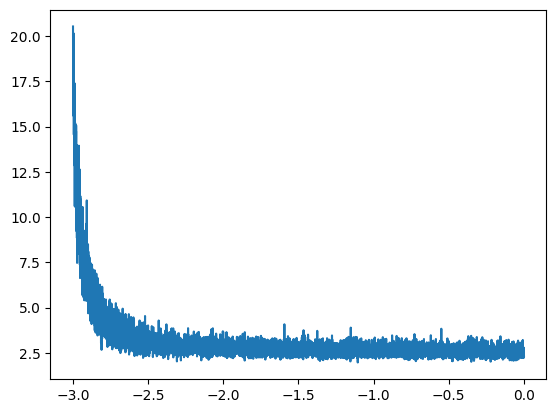

In [50]:
plt.plot(lri, lossi)

In [51]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss

tensor(2.5736, grad_fn=<NllLossBackward0>)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> TRAIN, VALIDATE, TEST APPROACH <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

In [52]:
import random

def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [53]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [54]:
sum(p.nelement() for p in parameters)

10281

In [55]:
for p in parameters:
    p.requires_grad = True

In [56]:
lri = []
lossi = []
stepi = []

In [66]:
for i in range(50000):

    # minibatch construct
    ix = torch.randint(0, Xtrain.shape[0], (32,))

    # forward pass
    emb = C[Xtrain[ix]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrain[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.item())

print("training complete")

training complete


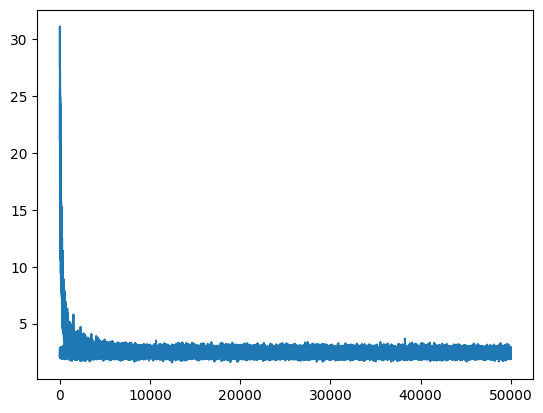

In [67]:
plt.plot(stepi, lossi)

In [68]:
emb = C[Xtrain]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytrain)
loss

tensor(2.3626, grad_fn=<NllLossBackward0>)

In [69]:
# Evaluate the trained model using the validation dataset
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3613, grad_fn=<NllLossBackward0>)

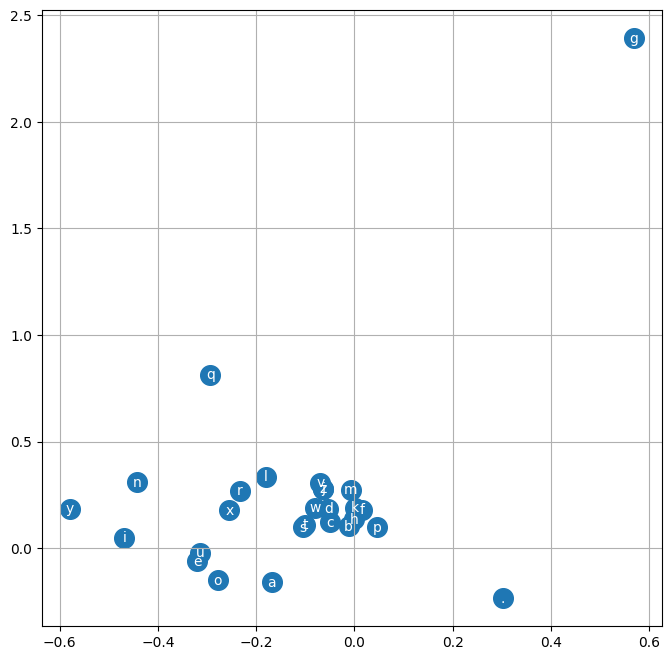

In [70]:
# Visualize the embeddings with 2 dimensions
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')

plt.grid('minor')

<<<<<<<<<<<<<<<<<<<<<<<<<< SCALING UP THE EMBEDDINGS TO (POSSIBLY) RESOLVE THE CONSTRAINT ON PERFORMANCE >>>>>>>>>>>>>>>>

In [71]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g) # Scale the dimension of input from 27x2 -> 27x10
W1 = torch.rand((30, 300), generator=g) # There are now 3x10 = 30 inputs into the second NN
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [72]:
sum(p.nelement() for p in parameters)

17697

In [73]:
for p in parameters:
    p.requires_grad = True

In [74]:
lri = []
lossi = []
stepi = []

In [81]:
for i in range(200000):

    # minibatch construct
    ix = torch.randint(0, Xtrain.shape[0], (32,))

    # forward pass
    emb = C[Xtrain[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrain[ix])

    # backward pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

print("training complete")
    

training complete


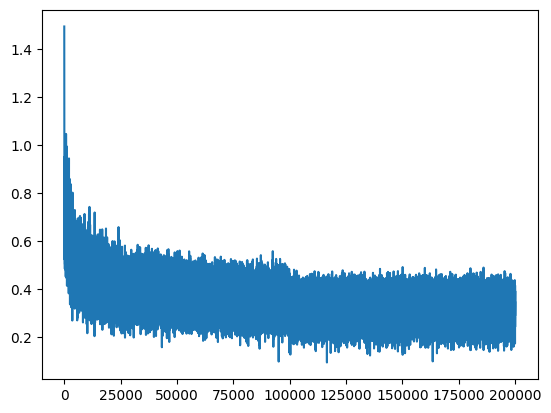

In [76]:
plt.plot(stepi, lossi)

In [78]:
emb = C[Xtrain]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytrain)
loss

tensor(2.0895, grad_fn=<NllLossBackward0>)

In [79]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1317, grad_fn=<NllLossBackward0>)

<<<<<<<<<<<<<<<<<<<<< SAMPLE FROM THE TRAINED MODEL <<<<<<<<<<<<<<<<<<<<<<<<<<<<

In [80]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mona.
amyah.
see.
madhayla.
remmanieldrie.
cadelyn.
elin.
shi.
jen.
eden.
estanaraelyn.
malka.
cayshabergihianna.
kindreelle.
xithana.
ubrence.
ryyah.
fael.
yuva.
miston.
